Acknowledgement: This project was largely motivated by the work of Michelle Lochner et al. (ApJ Supplement Series, 225:31, 2016), which can be accessed via this [link](https://iopscience.iop.org/article/10.3847/0067-0049/225/2/31).

In [57]:
# Note that this notebook was run on Google Colab,
# therefore, mounting it to Phong's Google Drive was necessary.
# If one runs it via Jupyter, this is not needed.
from google.colab import drive
drive.mount('/content/drive')

# When run locally via Jupyter, change dir to 'data/'
# dir = '/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/data/' # Phong
#dir = '/content/drive/My Drive/ML_Fall2025_Supernovae/data/' # Valarie
dir = '/content/drive/MyDrive/ML_Fall2025_Supernovae/updated_data/' # Trang

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#adjust font sizes for visibility on slides
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
})

# Step 1: Data Analysis

## First, we load datasets of both models.

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
# Model 1:
I_Ia = pd.read_csv(dir + 'model1_TypeIa_updated.csv').dropna()
I_Ibc = pd.read_csv(dir + 'model1_TypeIbc_updated.csv').dropna()
I_II = pd.read_csv(dir + 'model1_TypeII_updated.csv').dropna()
I_IIn = pd.read_csv(dir + 'model1_TypeIIn_updated.csv').dropna()
I_skip = ['sn_name', 'sn_type', 'band']
I_labels = ['Ia', 'Ibc', 'II', 'IIn']

In [106]:
I_Ia['sn_type'].unique(), I_Ibc['sn_type'].unique(), I_II['sn_type'].unique(), I_IIn['sn_type'].unique()

(array(['Ia', 'IaQ', 'Ia_Pec'], dtype=object),
 array(['Ic', 'Ib', 'Ib_c', 'Ic/Ic-BL', 'Ic_Pec', 'Ib-pec', 'IcQ'],
       dtype=object),
 array(['II', 'II_Pec', 'II_P', 'IIQ', 'II_L', 'IIP'], dtype=object),
 array(['IIn', 'IIn_Pec', 'IIn_LBV'], dtype=object))

In [107]:
# Model 2:
II_Ia = pd.read_csv(dir + 'model2_TypeIa_updated.csv').dropna()
II_Ibc = pd.read_csv(dir + 'model2_TypeIbc_updated.csv').dropna()
II_II = pd.read_csv(dir + 'model2_TypeII_updated.csv').dropna()
II_IIn = pd.read_csv(dir + 'model2_TypeIIn_updated.csv').dropna()
II_skip = ['sn_name', 'sn_type', 'band']
II_labels = ['Ia', 'Ibc', 'II', 'IIn']

Next, we inspect the statistics of the features in each dataset.

In [108]:
def histogram_all(dfs, skip, labels):
    cols = [c for c in dfs[0].columns if c not in skip] #dfs[0].columns[2:] to show bands

    n = len(cols)
    rows = (n + 2) // 2    # number of rows needed
    fig, axes = plt.subplots(rows, 2, figsize=(12, 3*rows))

    axes = axes.flatten()  # flatten so we can index axis[i]

    for i, column in enumerate(cols):
        ax = axes[i]

        # Plot histograms from all three datasets
        for j in range(len(dfs)):
            ax.hist(dfs[j][column], bins=30, alpha=0.5, label=labels[j])

        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        ax.legend()

    # Hide unused axes if columns not multiple of 3
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

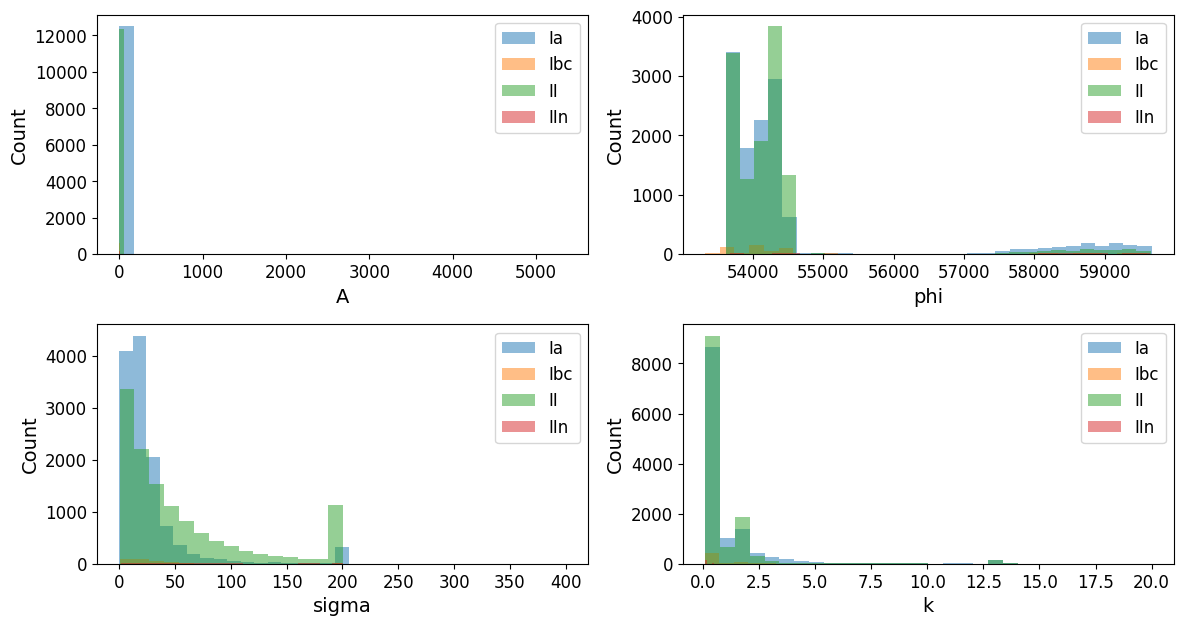

In [109]:
# Histograms for Model 1
histogram_all([I_Ia, I_Ibc, I_II, I_IIn], I_skip, I_labels)

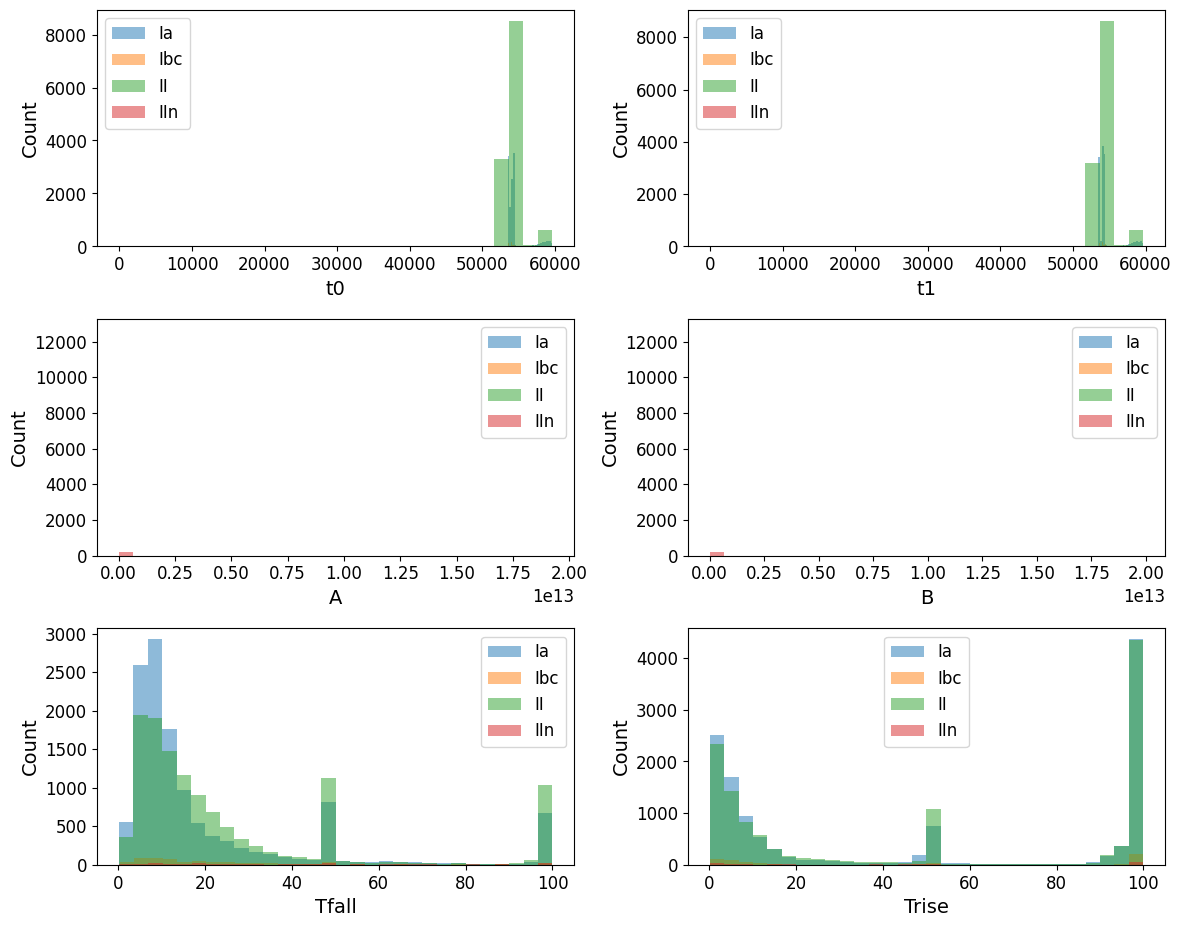

In [111]:
# Histograms for Model 2
histogram_all([II_Ia,II_Ibc,II_II,II_IIn],II_skip,II_labels)

Both these datasets show presence of outliers, which can skew the model. We use clipping technique to squeeze both dataset to their 25-75quantile intervals.

In [112]:
def clipping(dfs, skip):
    dfs_clipped = []
    feature_cols = dfs[0].columns[3:]

    for df in dfs:
        df_copy = df.copy()

        # Compute IQR only on feature columns
        Q1 = df_copy[feature_cols].quantile(0.25)
        Q3 = df_copy[feature_cols].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Clip only the feature columns
        df_copy[feature_cols] = df_copy[feature_cols].clip(lower=lower, upper=upper, axis=1)

        dfs_clipped.append(df_copy)

    return dfs_clipped

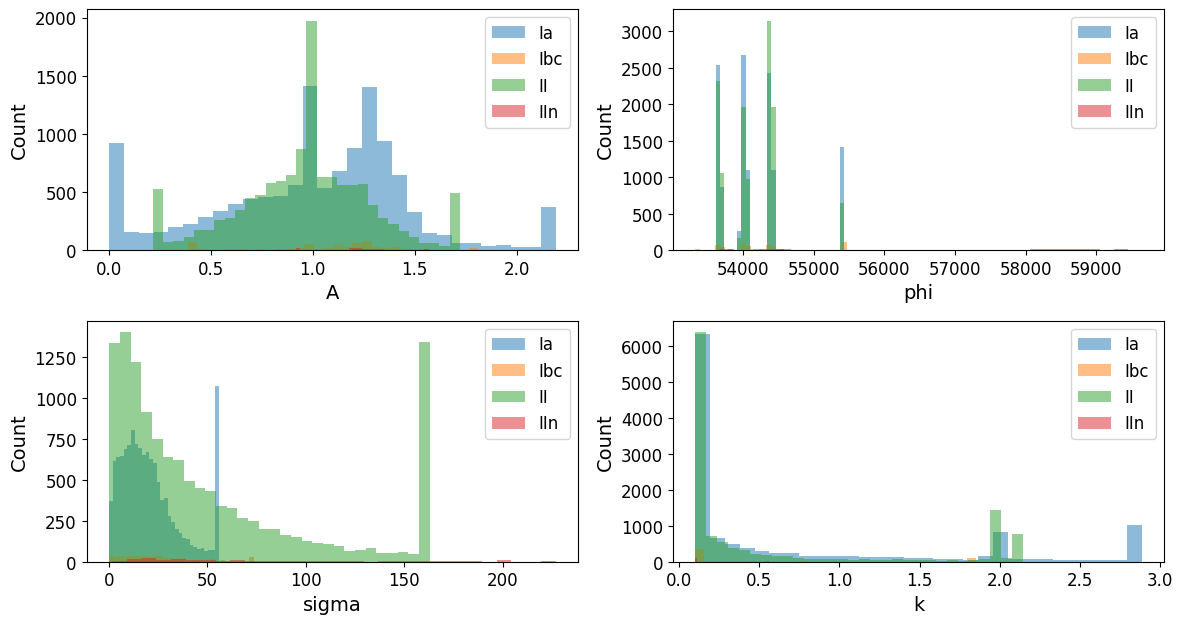

In [113]:
I_Ia_clip, I_Ibc_clip, I_II_clip, I_IIn_clip = clipping([I_Ia,I_Ibc,I_II, I_IIn], I_skip)
histogram_all([I_Ia_clip, I_Ibc_clip, I_II_clip, I_IIn_clip], I_skip, I_labels)

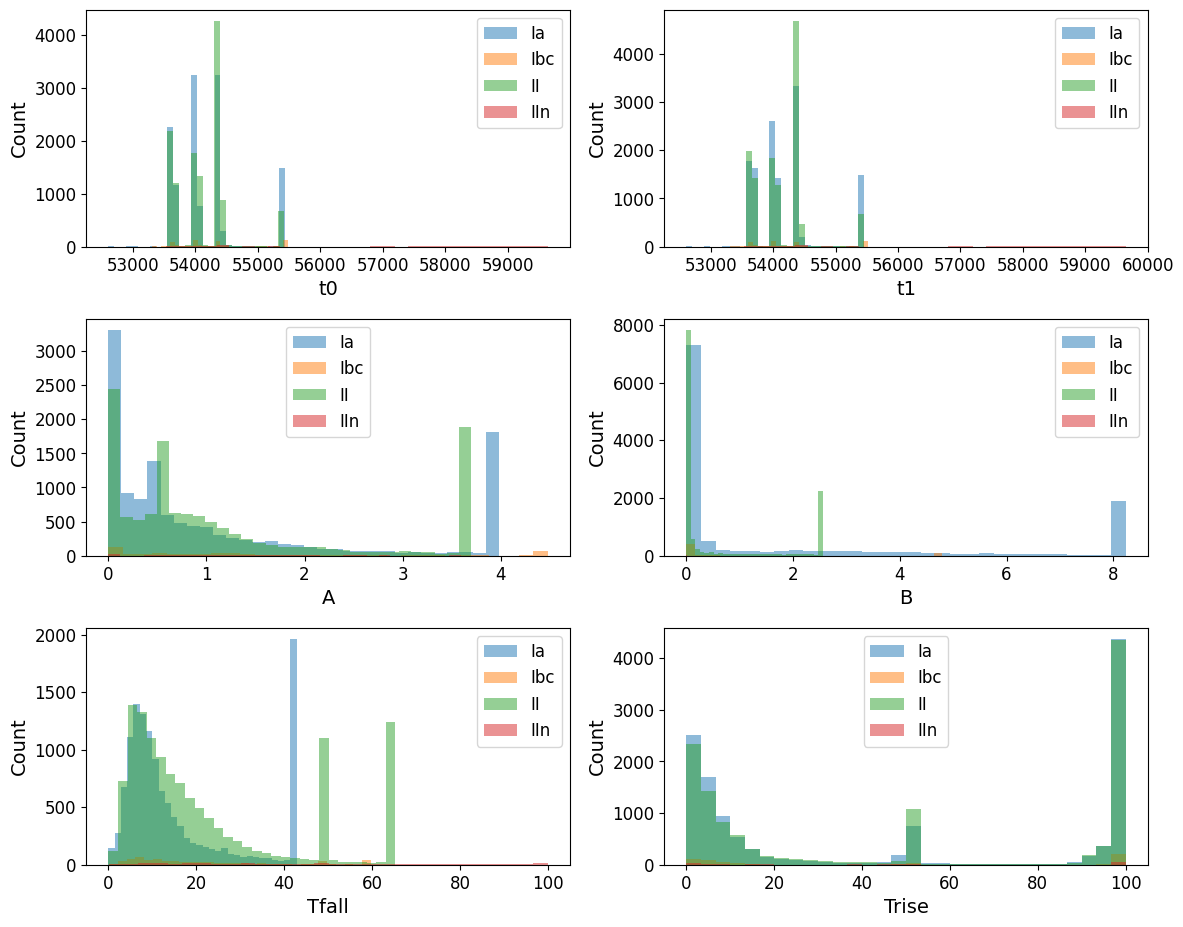

In [114]:
II_Ia_clip, II_Ibc_clip, II_II_clip, II_IIn_clip = clipping([II_Ia,II_Ibc,II_II,II_IIn], II_skip)
histogram_all([II_Ia_clip, II_Ibc_clip, II_II_clip, II_IIn_clip], II_skip, II_labels)


# Step 2: Prepare for training

In [115]:
from sklearn.preprocessing import RobustScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

## First, we define a function for evaluating performance of a model.

In [116]:
def evaluate_model(model, X_train, y_train, X_test, y_test, band_test, class_names=None, history=None):
  # Define all possible classes based on class_names
  if class_names is not None:
      classes_for_metrics = np.arange(len(class_names))
      n_classes = len(class_names)
  else:
      # Fallback if class_names is not provided, though it should be for proper display
      classes_for_metrics = np.unique(np.concatenate((y_train, y_test)))
      n_classes = len(classes_for_metrics)


  # Training set evaluation
  print("Training set:")

  if history is not None:  # Keras model
    y_train_scores = model.predict(X_train) # Keras predict returns probabilities (2D array)
    y_train_pred = np.argmax(y_train_scores, axis=1)
  else:  # Scikit-learn model
    if hasattr(model, "predict_proba"):
      y_train_scores = model.predict_proba(X_train) # Use predict_proba for probabilities (2D array)
      y_train_pred = np.argmax(y_train_scores, axis=1)
    else:
      y_train_pred = model.predict(X_train) # Use predict for labels (1D array)
      y_train_scores = None # Not available as true probabilities for ROC on training

  cm_train = confusion_matrix(y_train, y_train_pred, labels=classes_for_metrics) # Explicitly pass labels
  print("Accuracy:", accuracy_score(y_train, y_train_pred))
  print("\nClassification report:\n", classification_report(y_train, y_train_pred, labels=classes_for_metrics, target_names=class_names)) # Add labels and target_names
  print("\nConfusion matrix:\n", confusion_matrix(y_train, y_train_pred, labels=classes_for_metrics))
  disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
  disp_train.plot(cmap='Blues')

  # Test set evaluation
  print("\nTest set:")
  y_test_bin = label_binarize(y_test, classes=classes_for_metrics) # Use the universal classes for binarization

  # Predict probabilities (y_score) and labels (y_test_pred_all) for the test set
  if history is not None: # Keras model
    y_score = model.predict(X_test)
    y_test_pred_all = np.argmax(y_score, axis=1) # get labels from probabilities
  else: # Scikit-learn model
    if hasattr(model, "predict_proba"):
      y_score = model.predict_proba(X_test)
      y_test_pred_all = np.argmax(y_score, axis=1) # get labels from probabilities
    else:
      y_test_pred_all = model.predict(X_test) # get labels directly
      y_score = label_binarize(y_test_pred_all, classes=classes_for_metrics) # Binarize for ROC if only labels are available


  # Compute ROC thresholds (only if y_score is actually probabilities or binarized labels for ROC)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  roc_thresholds = dict()

  # Check if y_score is 2D (probabilities) before proceeding with ROC calculations
  if y_score.ndim == 2 and y_score.shape[1] == n_classes:
      for i in range(n_classes):
          # Ensure there are samples for this class in y_test_bin and y_score
          if np.any(y_test_bin[:, i]) or np.any(y_score[:, i] > 0): # Check if there is actual data for the class
            fpr[i], tpr[i], thresholds = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            # Youden's J statistic
            J = tpr[i] - fpr[i]
            ix = np.argmax(J)
            roc_thresholds[i] = thresholds[ix]
          else:
              print(f"Warning: No true samples or positive predictions for class {i} for ROC curve.")


      # Predict labels using ROC thresholds
      y_test_pred = np.full(X_test.shape[0], -2, dtype=int)  # Use -2 for unclassified

      not_classified = 0
      for j in range(X_test.shape[0]):
          above_thresh = [i for i in range(n_classes) if y_score[j, i] >= roc_thresholds.get(i, 1.0)] # Use .get with default 1.0 if class not in roc_thresholds
          if above_thresh:
              # choose class with highest probability among those exceeding threshold
              y_test_pred[j] = above_thresh[np.argmax([y_score[j, i] for i in above_thresh])]
          else:
              not_classified += 1
  else:
      # If y_score is not probabilities or properly binarized, fall back to y_test_pred_all
      y_test_pred = y_test_pred_all
      print("Warning: ROC curve cannot be plotted due to insufficient probability data or mismatch in dimensions.")


  print("\nNot classified:", not_classified)

  # Mask out unclassified samples before calculating confusion matrix for accuracy and report
  mask = y_test_pred != -2 # Use -2 for mask
  if np.sum(mask) == 0:
      print("No classified samples in the test set after thresholding.")
  else:
      cm_test = confusion_matrix(y_test[mask], y_test_pred[mask], labels=classes_for_metrics) # Explicitly pass labels
      print("Accuracy:", accuracy_score(y_test[mask], y_test_pred[mask]))
      print("\nClassification report:\n", classification_report(y_test[mask], y_test_pred[mask], labels=classes_for_metrics, target_names=class_names)) # Add labels and target_names
      print("\nConfusion matrix:\n", confusion_matrix(y_test[mask], y_test_pred[mask], labels=classes_for_metrics))
      disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)
      disp_test.plot(cmap='Blues')

  # Plot the ROC curves (only if roc_auc was calculated and there are values)
  if roc_auc and all(value for value in roc_auc.values() if not np.isnan(value)): # Check if roc_auc dictionary is populated and all values are non-NaN
      plt.figure(figsize=(7,6))

      colors = plt.cm.get_cmap('Set1', n_classes)
      for i in range(n_classes):
          if i in fpr and i in tpr: # Only plot if FPR/TPR were calculated for the class
              label = f"Class {i}" if class_names is None else class_names[i]
              plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                       label=f'{label} (AUC = {roc_auc[i]:.2f}, Threshold = {roc_thresholds.get(i, np.nan):.2f})')

      plt.plot([0,1], [0,1], 'k--', lw=1)
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Multi-class ROC Curve')
      plt.legend(loc='lower right')
      plt.grid(True)
      plt.show()

  # Plot XGBClassifier train/val loss if available
  if hasattr(model, "evals_result"):
    try:
      results = model.evals_result()
    except:
      results = model.get_booster().evals_result()

    train_key = list(results.keys())[0]
    val_key  = list(results.keys())[1]

    metric_name = list(results[train_key].keys())[0]

    train_loss = results[train_key][metric_name]
    val_loss   = results[val_key][metric_name]

    plt.figure(figsize=(7,6))
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.xlabel("Boosting Rounds")
    plt.ylabel('Loss')
    plt.title("XGBoost Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

  # Plot MLPClassifier train/val loss if available
  if history is not None:
    plt.figure(figsize=(7,6))
    plt.plot(history.history["loss"], label="Train loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("MLP Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

  if band_test is not None:
      print("\n==============================")
      print(" Per-band evaluation:")
      print("==============================")

      bands = sorted(band_test.unique())
      # y_test_pred_all is already calculated above

      for b in bands:
          idx = (band_test == b)
          y_true_b = y_test[idx]
          y_pred_b = y_test_pred_all[idx] # Use y_test_pred_all for per-band to match original output before ROC thresholding

          print(f"\n--- Band = {b} ---")
          print("Count:", len(y_true_b))
          if len(y_true_b) == 0:
              print("No samples in this band.")
              continue
          cm_b = confusion_matrix(y_true_b, y_pred_b, labels=classes_for_metrics)
          print("Accuracy:", accuracy_score(y_true_b, y_pred_b))
          print(classification_report(y_true_b, y_pred_b, labels=classes_for_metrics, target_names=class_names))
          print("Confusion matrix:\n", confusion_matrix(y_true_b, y_pred_b, labels=classes_for_metrics))
          disp_b = ConfusionMatrixDisplay(confusion_matrix=cm_b, display_labels=class_names)
          disp_b.plot(cmap='Blues')

## Second, we prepare features and labels.

In [120]:
# Model 1:
# Combining into a single dataset
I = pd.concat([I_Ia_clip, I_Ibc_clip, I_II_clip, I_IIn_clip], ignore_index=True)
I = I.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
I_feature_cols = [c for c in I.columns if c not in I_skip]
I_X = I[I_feature_cols]
I_band = I['band']

# Extracting labels
I_y = I['sn_type']
#print("Unique mapped labels:", I_y.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, and 2 for II, and 3 for IIn
I_name_Ia = ['Ia','IaQ','Ia_Pec']
I_name_II = ['II','II_P','IIP','IIQ','II_L','II_Pec']
I_name_IIn = ['IIn', 'IIn_LBV', 'IIn_Pec']
I_y = I_y.apply(lambda v: 0 if v in I_name_Ia else (2 if v in I_name_II else (3 if v in I_name_IIn else 1)))

# Split data into 70/20/10 and scale
I_X_temp, I_X_test, I_y_temp, I_y_test, I_band_temp, I_band_test = train_test_split(
    I_X, I_y, I_band,
    test_size=0.1,
    random_state=42,
    stratify=I_y,
    shuffle=True
)

I_X_train, I_X_val, I_y_train, I_y_val, I_band_train, I_band_val = train_test_split(
    I_X_temp, I_y_temp, I_band_temp,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=I_y_temp,
    shuffle=True
)

I_scaler = RobustScaler()
I_X_train = I_scaler.fit_transform(I_X_train)
I_X_val = I_scaler.fit_transform(I_X_val)
I_X_test = I_scaler.transform(I_X_test)

# Compute weights
I_classes = np.unique(I_y_train)
print(I_classes)
I_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=I_classes,
    y=I_y_train
)
I_class_weights = dict(zip(I_classes, I_class_weights))
I_sample_weights = np.array([I_class_weights[label] for label in I_y_train])

# Count examples in classes
print("Total:\n",pd.Series(I_y).value_counts())
print("Train:\n",pd.Series(I_y_train).value_counts())
print("Validation:\n",pd.Series(I_y_val).value_counts())
print("Test:\n",pd.Series(I_y_test).value_counts())

[0 1 2 3]
Total:
 sn_type
0    12528
2    12396
1      596
3      181
Name: count, dtype: int64
Train:
 sn_type
0    8769
2    8677
1     417
3     127
Name: count, dtype: int64
Validation:
 sn_type
0    2506
2    2479
1     119
3      36
Name: count, dtype: int64
Test:
 sn_type
0    1253
2    1240
1      60
3      18
Name: count, dtype: int64


In [122]:
# Model 2:
# Combining into a single dataset
II = pd.concat([II_Ia_clip, II_Ibc_clip, II_II_clip, II_IIn_clip], ignore_index=True)
II = II.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
II_feature_cols = [c for c in II.columns if c not in II_skip]
II_X = II[II_feature_cols]
II_band = II['band']

# Extracting labels
II_y = II['sn_type']
print("Unique mapped labels:", II_y.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, 2 for II and 3 for IIn
II_name_Ia = ['Ia','IaQ','Ia_Pec']
II_name_II = ['II','II_P','IIP','IIQ','II_L','II_Pec']
II_name_IIn = ['IIn', 'IIn_LBV', 'IIn_Pec']
II_y = II_y.apply(lambda v: 0 if v in II_name_Ia else (2 if v in II_name_II else (3 if v in II_name_IIn else 1)))

# Split data and scale
II_X_temp, II_X_test, II_y_temp, II_y_test, II_band_temp, II_band_test = train_test_split(
    II_X, II_y, II_band,
    test_size=0.1,
    random_state=42,
    stratify=II_y,
    shuffle=True
)

II_X_train, II_X_val, II_y_train, II_y_val, II_band_train, II_band_val = train_test_split(
    II_X_temp, II_y_temp, II_band_temp,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=II_y_temp,
    shuffle=True
)

II_scaler = RobustScaler()
II_X_train = II_scaler.fit_transform(II_X_train)
II_X_val = II_scaler.fit_transform(II_X_val)
II_X_test = II_scaler.transform(II_X_test)

# Compute weights
II_classes = np.unique(II_y_train)
II_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=II_classes,
    y=II_y_train
)
II_class_weights = dict(zip(II_classes, II_class_weights))
II_sample_weights = np.array([II_class_weights[label] for label in II_y_train])

# Count examples in classes
print("Total:\n",pd.Series(II_y).value_counts())
print("Train:\n",pd.Series(II_y_train).value_counts())
print("Validation:\n",pd.Series(II_y_val).value_counts())
print("Test:\n",pd.Series(II_y_test).value_counts())

Unique mapped labels: ['Ib_c' 'Ia' 'II' 'IIn' 'IIQ' 'IaQ' 'II_P' 'IIn_LBV' 'II_Pec' 'Ib' 'Ic'
 'Ic_Pec' 'Ia_Pec' 'IcQ' 'IIP' 'II_L' 'IIn_Pec' 'Ib-pec' 'Ic/Ic-BL']
Total:
 sn_type
0    12637
2    12481
1      604
3      199
Name: count, dtype: int64
Train:
 sn_type
0    8846
2    8736
1     423
3     139
Name: count, dtype: int64
Validation:
 sn_type
0    2527
2    2496
1     121
3      40
Name: count, dtype: int64
Test:
 sn_type
0    1264
2    1249
1      60
3      20
Name: count, dtype: int64


It can be seen that both datasets have very strong imbalance between classes. We try downsampling.

In [123]:
# Model 1:
# Combining into a single dataset
I_down = pd.concat([I_Ia_clip.sample(1000), I_Ibc_clip, I_II_clip.sample(1000), I_IIn_clip], ignore_index=True)
I_down = I_down.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
I_X_down = I_down[I_feature_cols]
I_band_down = I_down['band']

# Extracting labels
I_y_down = I_down['sn_type']
#print("Unique mapped labels:", I_y_down.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, and 2 for II
I_y_down = I_y_down.apply(lambda v: 0 if v in I_name_Ia else (2 if v in I_name_II else (3 if v in I_name_IIn else 1)))

# Split data into 70/20/10 and scale
I_X_temp_down, I_X_test_down, I_y_temp_down, I_y_test_down, I_band_temp_down, I_band_test_down = train_test_split(
    I_X_down, I_y_down, I_band_down,
    test_size=0.1,
    random_state=42,
    stratify=I_y_down,
    shuffle=True
)

I_X_train_down, I_X_val_down, I_y_train_down, I_y_val_down, I_band_train_down, I_band_val_down = train_test_split(
    I_X_temp_down, I_y_temp_down, I_band_temp_down,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=I_y_temp_down,
    shuffle=True
)

I_scaler_down = RobustScaler()
I_X_train_down = I_scaler_down.fit_transform(I_X_train_down)
I_X_val_down = I_scaler_down.fit_transform(I_X_val_down)
I_X_test_down = I_scaler_down.transform(I_X_test_down)

# Compute weights
I_class_weights_down = compute_class_weight(
    class_weight='balanced',
    classes=I_classes,
    y=I_y_train_down
)
I_class_weights_down = dict(zip(I_classes, I_class_weights_down))
I_sample_weights_down = np.array([I_class_weights_down[label] for label in I_y_train_down])

# Count examples in classes
print("Total:\n",pd.Series(I_y_down).value_counts())
print("Train:\n",pd.Series(I_y_train_down).value_counts())
print("Validation:\n",pd.Series(I_y_val_down).value_counts())
print("Test:\n",pd.Series(I_y_test_down).value_counts())

Total:
 sn_type
0    1000
2    1000
1     596
3     181
Name: count, dtype: int64
Train:
 sn_type
2    700
0    700
1    417
3    126
Name: count, dtype: int64
Validation:
 sn_type
0    200
2    200
1    119
3     37
Name: count, dtype: int64
Test:
 sn_type
0    100
2    100
1     60
3     18
Name: count, dtype: int64


In [126]:
# Model 2:
# Combining into a single dataset
II_down = pd.concat([II_Ia_clip.sample(2000), II_Ibc_clip, II_II_clip, II_IIn_clip], ignore_index=True)
II_down = II_down.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
II_X_down = II_down[II_feature_cols]
II_band_down = II_down['band']

# Extracting labels
II_y_down = II_down['sn_type']
#print("Unique mapped labels:", II_y.unique())

# Encode categorical labels
# II_y_down = II_y_down.apply(lambda v: 0 if v in II_name_Ia else (2 if v in II_name_II else (3 if v in II_name_IIn else 1)))
II_y_down = II_y_down.apply(lambda v: 0 if v in II_name_Ia else (2 if v in II_name_II else (3 if v in II_name_IIn else 1)))

# Split data into 70/20/10 and scale
II_X_temp_down, II_X_test_down, II_y_temp_down, II_y_test_down, II_band_temp_down, II_band_test_down = train_test_split(
    II_X_down, II_y_down, II_band_down,
    test_size=0.1,
    random_state=42,
    stratify=II_y_down,
    shuffle=True
)

II_X_train_down, II_X_val_down, II_y_train_down, II_y_val_down, II_band_train_down, II_band_val_down = train_test_split(
    II_X_temp_down, II_y_temp_down, II_band_temp_down,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=II_y_temp_down,
    shuffle=True
)

II_scaler_down = RobustScaler()
II_X_train_down = II_scaler_down.fit_transform(II_X_train_down)
II_X_val_down = II_scaler_down.fit_transform(II_X_val_down)
II_X_test_down = II_scaler_down.transform(II_X_test_down)

# Compute weights
II_class_weights_down = compute_class_weight(
    class_weight='balanced',
    classes=II_classes,
    y=II_y_train_down
)
II_class_weights_down = dict(zip(II_classes, II_class_weights_down))
II_sample_weights_down = np.array([II_class_weights_down[label] for label in II_y_train_down])

# Count examples in classes
print("Total:\n",pd.Series(II_y_down).value_counts())
print("Train:\n",pd.Series(II_y_train_down).value_counts())
print("Validation:\n",pd.Series(II_y_val_down).value_counts())
print("Test:\n",pd.Series(II_y_test_down).value_counts())

Total:
 sn_type
2    12481
0     2000
1      604
3      199
Name: count, dtype: int64
Train:
 sn_type
2    8736
0    1400
1     423
3     139
Name: count, dtype: int64
Validation:
 sn_type
2    2496
0     400
1     121
3      40
Name: count, dtype: int64
Test:
 sn_type
2    1249
0     200
1      60
3      20
Name: count, dtype: int64


# Step 3: Multi-layer perceptron classifier

In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## Model 1

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2789 - loss: 2.1407 - val_accuracy: 0.3430 - val_loss: 1.2307
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3743 - loss: 1.3470 - val_accuracy: 0.3671 - val_loss: 1.1912
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3907 - loss: 1.2003 - val_accuracy: 0.4471 - val_loss: 1.1205
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4055 - loss: 1.1352 - val_accuracy: 0.4809 - val_loss: 1.0691
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4179 - loss: 1.1100 - val_accuracy: 0.4648 - val_loss: 1.0664
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4230 - loss: 1.1295 - val_accuracy: 0.4949 - val_loss: 1.0518
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4273 - loss: 1.0829 - val_accuracy: 0.4597 - val_loss: 1.0482
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4164 - loss: 1.0603 - val_accuracy: 0.

/tmp/ipython-input-1839754131.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


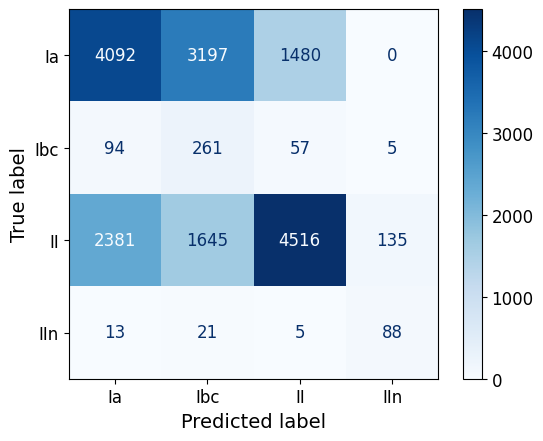

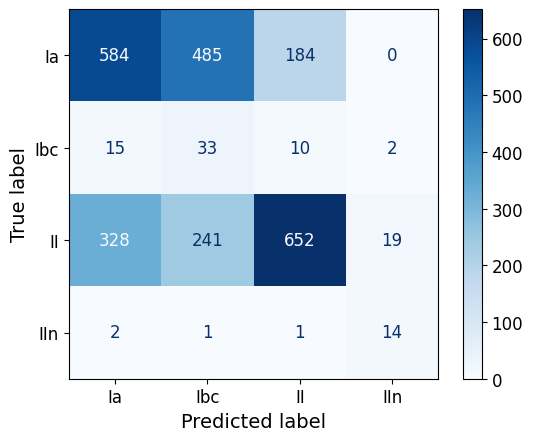

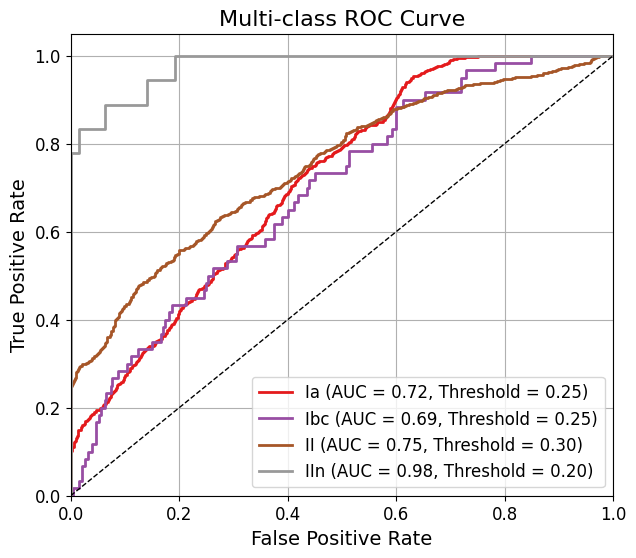

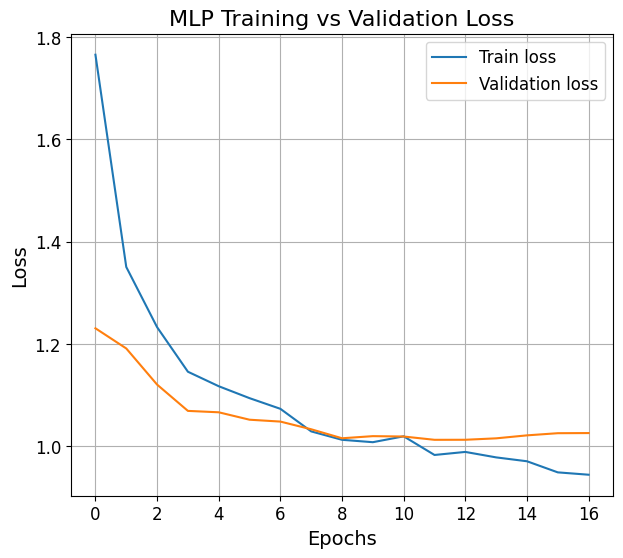


 Per-band evaluation:
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

--- Band = G ---
Count: 250
Accuracy: 0.16
              precision    recall  f1-score   support

           0       0.89      0.10      0.18       161
           1       0.05      0.83      0.09        12
           2       0.00      0.00      0.00        63
           3       0.56      1.00      0.72        14

    accuracy                           0.16       250
   macro avg       0.37      0.48      0.25       250
weighted avg       0.61      0.16      0.16       250

Confusion matrix:
 [[ 16 144   1   0]
 [  0  10   0   2]
 [  2  52   0   9]
 [  0   0   0  14]]

--- Band = g' ---
Count: 418
Accuracy: 0.5406698564593302
              precision    recall  f1-score   support

           0       0.64      0.56      0.60       192
           1       0.03      0.50      0.06         8
           2       0.86      0.53      0.65       218

    accuracy                           0.54       418
   macro avg       0.51      0.

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (4).

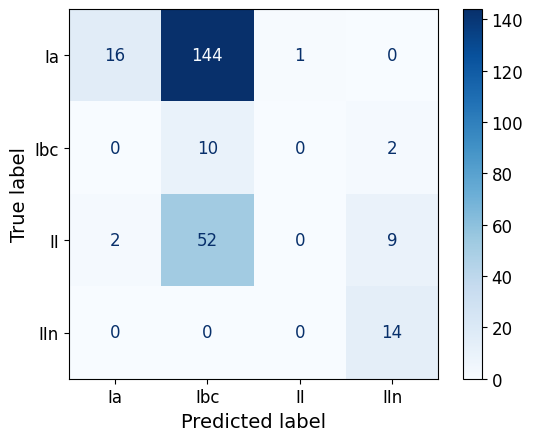

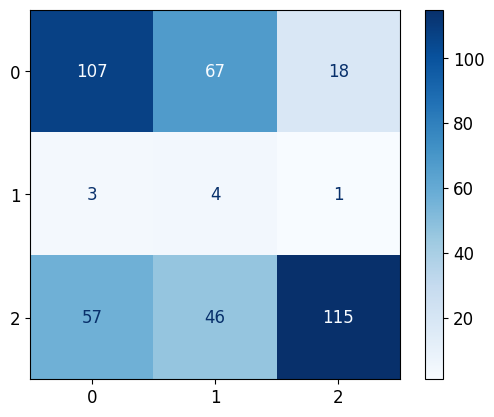

In [51]:
# Model 1 without downsampling
I_mlp = models.Sequential([
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

I_mlp.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

I_history = I_mlp.fit(
    I_X_train, I_y_train,
    validation_data=(I_X_val, I_y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    class_weight=I_class_weights
)

evaluate_model(I_mlp, I_X_train, I_y_train, I_X_test, I_y_test, I_band_test, I_labels, I_history)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.3016 - loss: 1.3654 - val_accuracy: 0.3607 - val_loss: 1.3703
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3190 - loss: 1.3894 - val_accuracy: 0.3411 - val_loss: 1.3602
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2423 - loss: 1.3665 - val_accuracy: 0.4393 - val_loss: 1.3456
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3146 - loss: 1.3651 - val_accuracy: 0.4304 - val_loss: 1.3340
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4019 - loss: 1.3277 - val_accuracy: 0.4464 - val_loss: 1.3263
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3621 - loss: 1.3692 - val_accuracy: 0.4446 - val_loss: 1.3142
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4076 - loss: 1.3439 - val_accuracy: 0.4482 - val_loss: 1.2975
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4027 - loss: 1.3046 - val_accuracy: 0.4714 - v

/tmp/ipython-input-1531764694.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


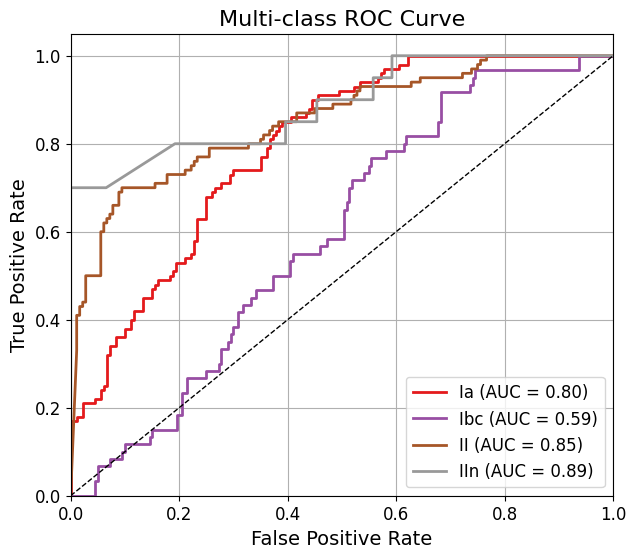

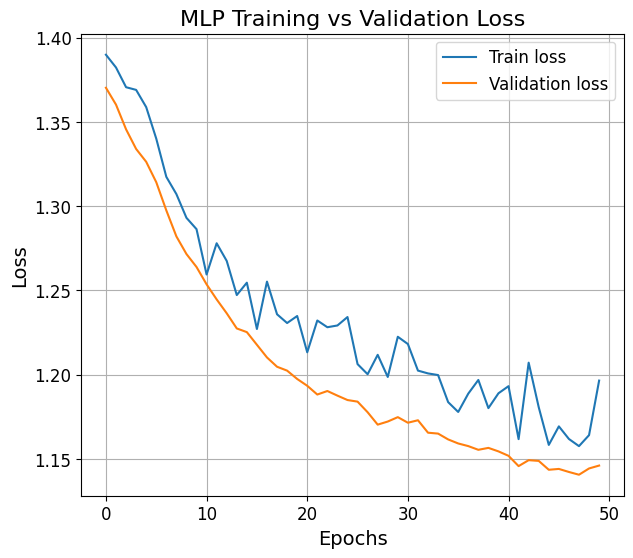


 Per-band evaluation:
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

--- Band = G ---
Count: 44
Accuracy: 0.45454545454545453
              precision    recall  f1-score   support

           0       1.00      0.18      0.31        11
           1       0.25      0.29      0.27        14
           2       0.00      0.00      0.00         5
           3       0.56      1.00      0.72        14

    accuracy                           0.45        44
   macro avg       0.45      0.37      0.32        44
weighted avg       0.51      0.45      0.39        44

Confusion matrix:
 [[ 2  9  0  0]
 [ 0  4  1  9]
 [ 0  3  0  2]
 [ 0  0  0 14]]

--- Band = g' ---
Count: 46
Accuracy: 0.6521739130434783
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        15
           1       0.00      0.00      0.00         9
           2       0.83      0.75      0.79        20
           3       0.00      0.00      0.00         2

    accuracy                        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
# Model 1 with downsampling
I_mlp_down = models.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

I_mlp_down.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

I_history_down = I_mlp_down.fit(
    I_X_train_down, I_y_train_down,
    validation_data=(I_X_val_down, I_y_val_down),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    class_weight=I_class_weights_down
)

evaluate_model(I_mlp_down, I_X_train_down, I_y_train_down, I_X_test_down, I_y_test_down, I_band_test_down, I_labels, I_history_down)

## Model 2

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6969 - loss: 0.9918 - val_accuracy: 0.8076 - val_loss: 0.5619
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7906 - loss: 0.6106 - val_accuracy: 0.8119 - val_loss: 0.5292
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8135 - loss: 0.5452 - val_accuracy: 0.8186 - val_loss: 0.5134
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8133 - loss: 0.5235 - val_accuracy: 0.8229 - val_loss: 0.5009
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8237 - loss: 0.4987 - val_accuracy: 0.8237 - val_loss: 0.4950
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8190 - loss: 0.4991 - val_accuracy: 0.8314 - val_loss: 0.4914
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8240 - loss: 0.4942 - val_accuracy: 0.8322 - val_loss: 0.4846
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8203 - loss: 0.4892 - val_accuracy: 0.8288 - val_

/tmp/ipython-input-3944701099.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


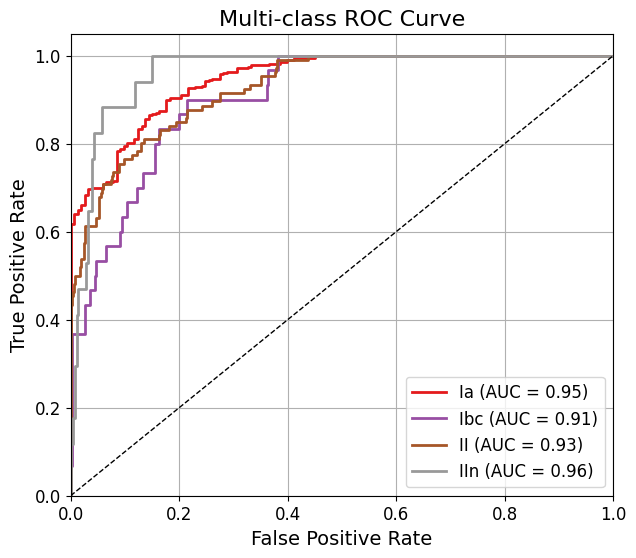

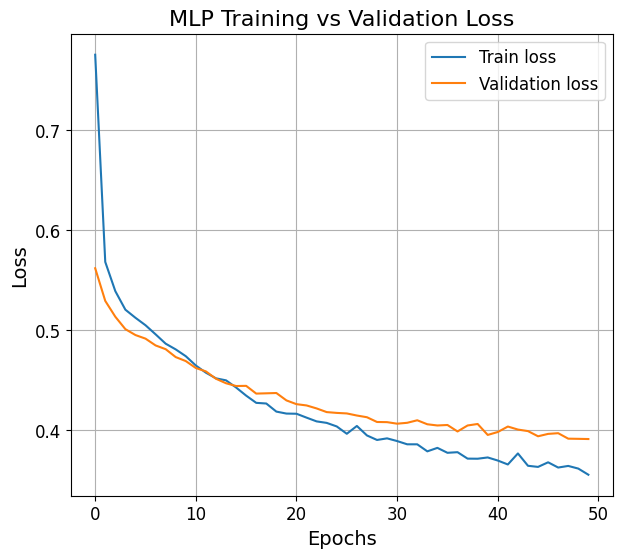


 Per-band evaluation:
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

--- Band = G ---
Count: 225
Accuracy: 0.8044444444444444
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       136
           1       1.00      0.18      0.31        11
           2       0.73      0.70      0.72        63
           3       1.00      0.07      0.12        15

    accuracy                           0.80       225
   macro avg       0.89      0.48      0.51       225
weighted avg       0.82      0.80      0.77       225

Confusion matrix:
 [[134   0   2   0]
 [  3   2   6   0]
 [ 19   0  44   0]
 [  6   0   8   1]]

--- Band = g' ---
Count: 61
Accuracy: 0.9180327868852459
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        52
           1       0.00      0.00      0.00         1
           2       1.00      0.50      0.67         8

    accuracy                           0.92        61
   macro avg      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
# Model 2 without downsampling
II_mlp = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(6,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

II_mlp.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

II_history = II_mlp.fit(
    II_X_train, II_y_train,
    validation_data=(II_X_val, II_y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=II_class_weights
)

evaluate_model(II_mlp, II_X_train, II_y_train, II_X_test, II_y_test, II_band_test,II_labels, II_history)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5404 - loss: 1.1541 - val_accuracy: 0.7044 - val_loss: 0.8106
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6783 - loss: 0.8271 - val_accuracy: 0.7030 - val_loss: 0.7726
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6903 - loss: 0.7667 - val_accuracy: 0.7143 - val_loss: 0.7562
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6961 - loss: 0.7427 - val_accuracy: 0.7171 - val_loss: 0.7414
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6897 - loss: 0.7474 - val_accuracy: 0.7214 - val_loss: 0.7300
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7108 - loss: 0.7334 - val_accuracy: 0.7171 - val_loss: 0.7205
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6919 - loss: 0.7224 - val_accuracy: 0.7016 - val_loss: 0.7150
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6970 - loss: 0.7126 - val_accuracy: 0.7214 - val_loss: 0.7029
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-3944701099.py:45: MatplotlibDe

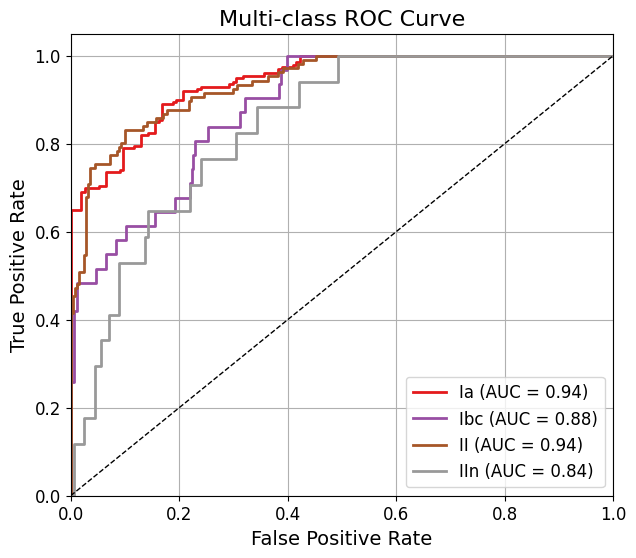

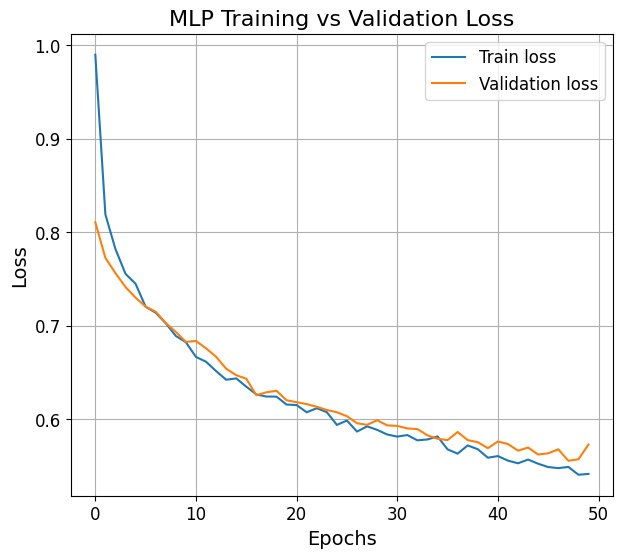


 Per-band evaluation:
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Band = G ---
Count: 144
Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        64
           1       1.00      0.12      0.22         8
           2       0.78      0.85      0.81        61
           3       0.00      0.00      0.00        11

    accuracy                           0.78       144
   macro avg       0.64      0.47      0.47       144
weighted avg       0.73      0.78      0.73       144

Confusion matrix:
 [[59  0  5  0]
 [ 4  1  3  0]
 [ 9  0 52  0]
 [ 4  0  7  0]]

--- Band = g' ---
Count: 39
Accuracy: 0.8461538461538461
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        27
           1       1.00      0.50      0.67         2
           2       1.00      0.56      0.71         9
           3       0.00      0.00      0.00         1

    accuracy                      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
# Model 2 with downsampling
II_mlp_down = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(6,)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

II_mlp_down.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

II_history_down = II_mlp_down.fit(
    II_X_train_down, II_y_train_down,
    validation_data=(II_X_val_down, II_y_val_down),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=II_class_weights_down
)

evaluate_model(II_mlp_down, II_X_train_down, II_y_train_down, II_X_test_down, II_y_test_down, II_band_test_down, II_labels, II_history_down)

Observation: Model 2 outperforms Model 1 with or without downsampling. Downsampling makes it worse for the classifier.

# Step 4: Support vector machine classifier

In [127]:
from sklearn.svm import SVC

## Model 1

Training set:
Accuracy: 0.7033351862145637

Classification report:
               precision    recall  f1-score   support

          Ia       0.68      0.79      0.73      8769
         Ibc       0.00      0.00      0.00       417
          II       0.74      0.65      0.69      8677
         IIn       0.57      0.19      0.28       127

    accuracy                           0.70     17990
   macro avg       0.50      0.41      0.43     17990
weighted avg       0.69      0.70      0.69     17990


Confusion matrix:
 [[6955    0 1811    3]
 [ 268    0  149    0]
 [2988    0 5674   15]
 [  50    0   53   24]]

Test set:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Not classified: 0
Accuracy: 0.7183975106962271

Classification report:
               precision    recall  f1-score   support

          Ia       0.70      0.80      0.75      1253
         Ibc       0.17      0.08      0.11        60
          II       0.76      0.67      0.71      1240
         IIn       0.54      0.78      0.64        18

    accuracy                           0.72      2571
   macro avg       0.54      0.58      0.55      2571
weighted avg       0.72      0.72      0.71      2571


Confusion matrix:
 [[1003   11  235    4]
 [  35    5   20    0]
 [ 394   13  825    8]
 [   1    1    2   14]]


/tmp/ipython-input-1703115811.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


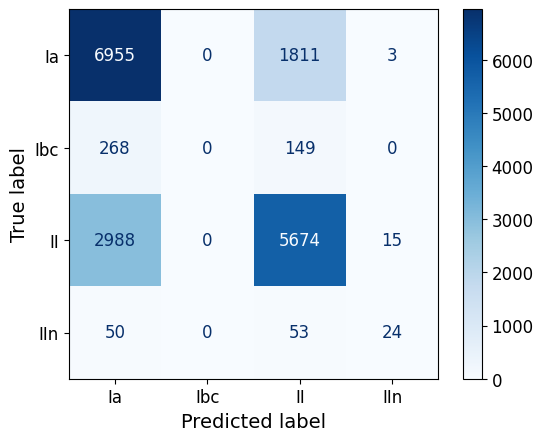

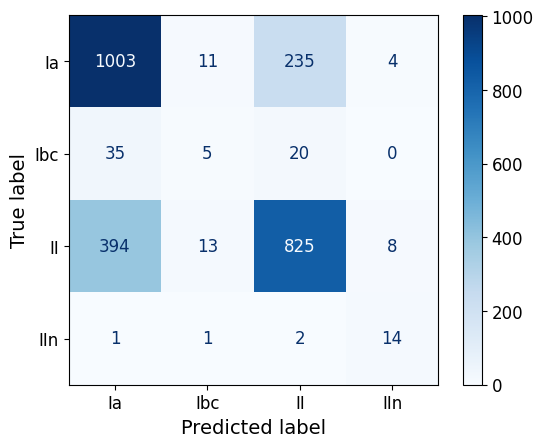

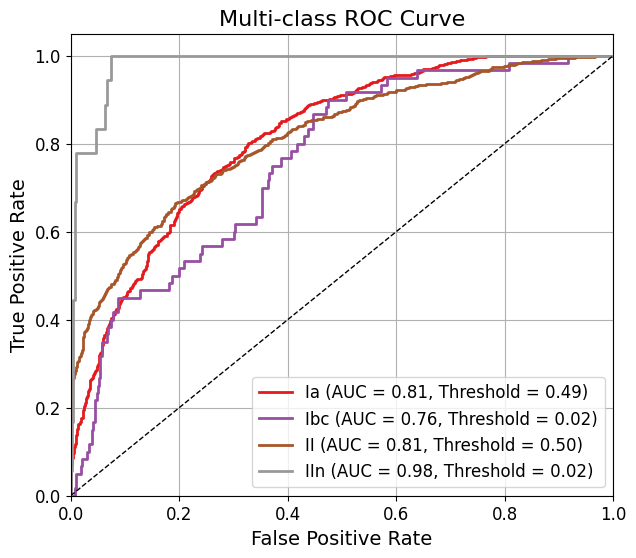


 Per-band evaluation:

--- Band = G ---
Count: 250
Accuracy: 0.764
              precision    recall  f1-score   support

          Ia       0.80      0.94      0.86       161
         Ibc       0.00      0.00      0.00        12
          II       0.64      0.57      0.61        63
         IIn       1.00      0.21      0.35        14

    accuracy                           0.76       250
   macro avg       0.61      0.43      0.46       250
weighted avg       0.73      0.76      0.73       250

Confusion matrix:
 [[152   0   9   0]
 [  7   0   5   0]
 [ 27   0  36   0]
 [  5   0   6   3]]

--- Band = g' ---
Count: 418
Accuracy: 0.7105263157894737
              precision    recall  f1-score   support

          Ia       0.64      0.86      0.74       192
         Ibc       0.00      0.00      0.00         8
          II       0.81      0.61      0.69       218
         IIn       0.00      0.00      0.00         0

    accuracy                           0.71       418
   macro avg    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


--- Band = r' ---
Count: 503
Accuracy: 0.7673956262425448
              precision    recall  f1-score   support

          Ia       0.70      0.88      0.78       222
         Ibc       0.00      0.00      0.00        13
          II       0.86      0.72      0.78       265
         IIn       0.00      0.00      0.00         3

    accuracy                           0.77       503
   macro avg       0.39      0.40      0.39       503
weighted avg       0.76      0.77      0.76       503

Confusion matrix:
 [[195   0  27   0]
 [ 10   0   3   0]
 [ 72   0 191   2]
 [  2   0   1   0]]

--- Band = u' ---
Count: 463
Accuracy: 0.6868250539956804
              precision    recall  f1-score   support

          Ia       0.67      0.76      0.71       228
         Ibc       0.00      0.00      0.00         9
          II       0.71      0.64      0.67       225
         IIn       0.00      0.00      0.00         1

    accuracy                           0.69       463
   macro avg       0.34  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

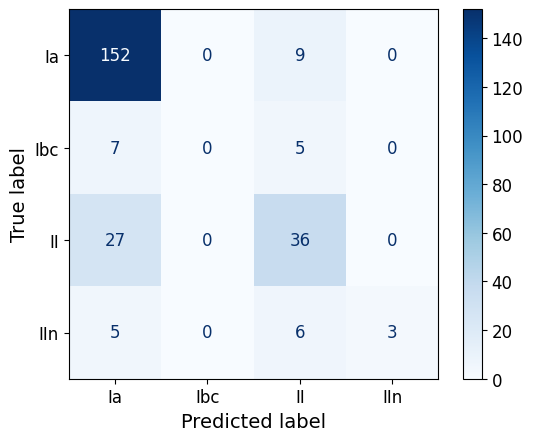

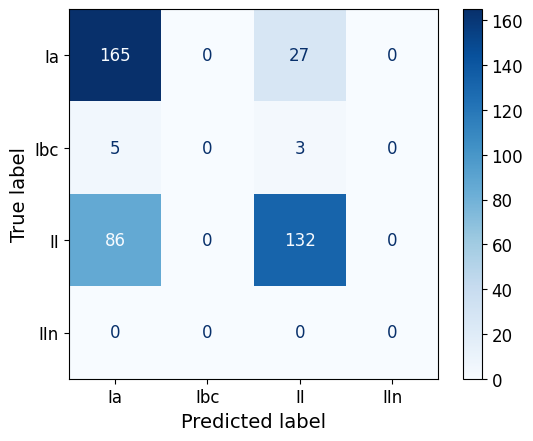

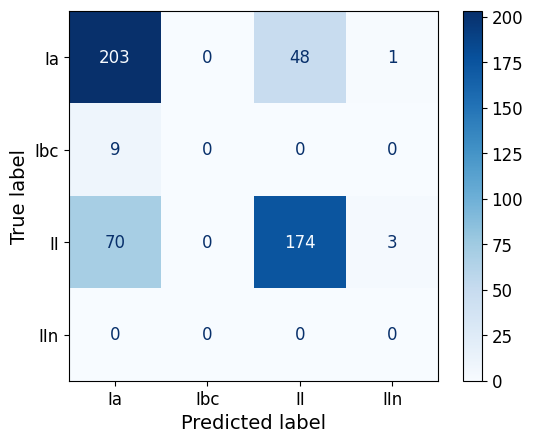

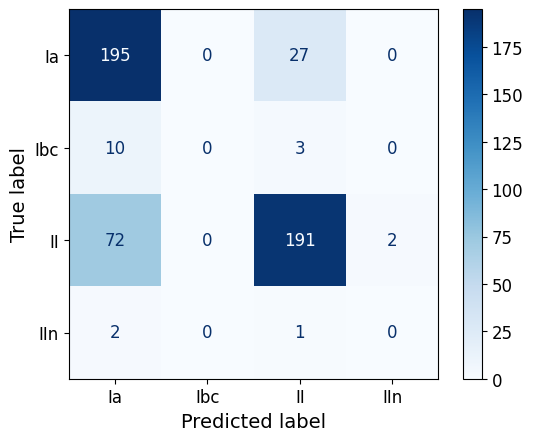

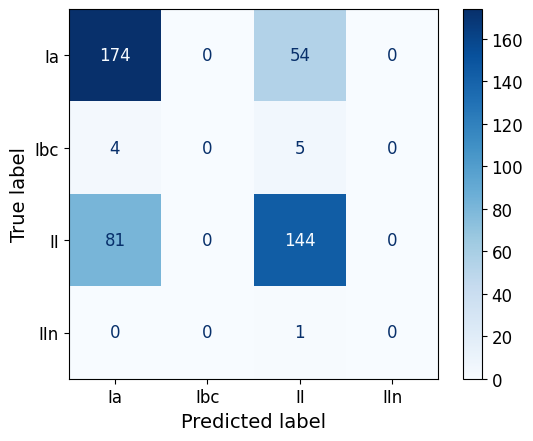

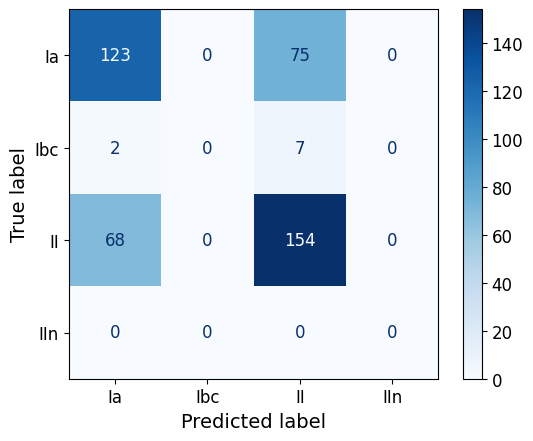

In [128]:
# Model 1 without downsampling
I_svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

I_svm.fit(I_X_train, I_y_train)
evaluate_model(I_svm, I_X_train, I_y_train, I_X_test, I_y_test, I_band_test, I_labels)

Training set:
Accuracy: 0.5666495110653629

Classification report:
               precision    recall  f1-score   support

          Ia       0.51      0.68      0.58       700
         Ibc       0.47      0.32      0.38       417
          II       0.65      0.59      0.62       700
         IIn       0.92      0.65      0.76       126

    accuracy                           0.57      1943
   macro avg       0.64      0.56      0.59      1943
weighted avg       0.58      0.57      0.56      1943


Confusion matrix:
 [[474  99 127   0]
 [196 135  85   1]
 [235  49 410   6]
 [ 27   6  11  82]]

Test set:

Not classified: 0
Accuracy: 0.48201438848920863

Classification report:
               precision    recall  f1-score   support

          Ia       0.48      0.68      0.56       100
         Ibc       0.42      0.27      0.33        60
          II       0.51      0.49      0.50       100
         IIn       0.50      0.06      0.10        18

    accuracy                           0.48

/tmp/ipython-input-1703115811.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


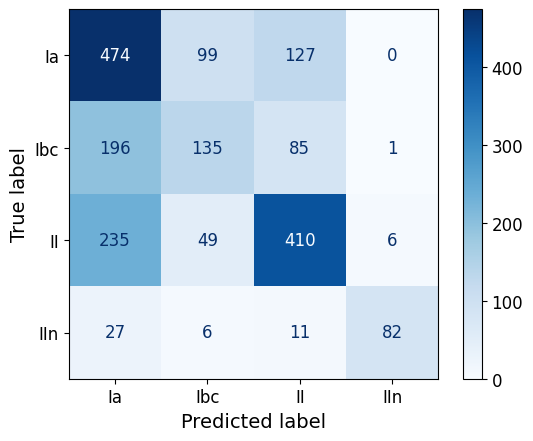

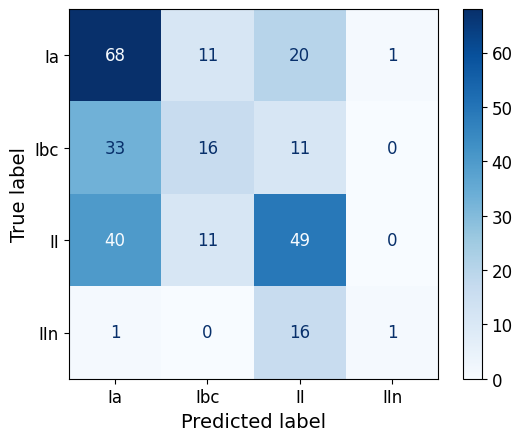

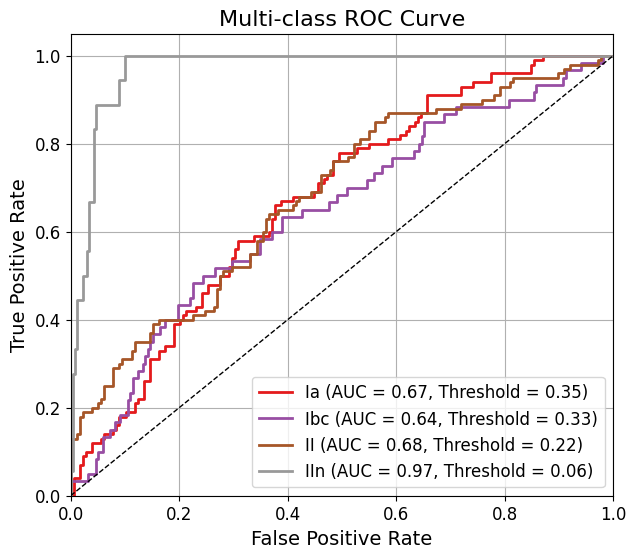


 Per-band evaluation:

--- Band = G ---
Count: 37
Accuracy: 0.24324324324324326
              precision    recall  f1-score   support

          Ia       0.36      1.00      0.53         5
         Ibc       0.30      0.33      0.32         9
          II       0.00      0.00      0.00        10
         IIn       1.00      0.08      0.14        13

    accuracy                           0.24        37
   macro avg       0.41      0.35      0.25        37
weighted avg       0.47      0.24      0.20        37

Confusion matrix:
 [[ 5  0  0  0]
 [ 6  3  0  0]
 [ 3  7  0  0]
 [ 0  0 12  1]]

--- Band = g' ---
Count: 45
Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

          Ia       0.55      0.60      0.57        20
         Ibc       0.44      0.57      0.50         7
          II       0.64      0.50      0.56        18
         IIn       0.00      0.00      0.00         0

    accuracy                           0.56        45
   macro avg       0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me


--- Band = r' ---
Count: 57
Accuracy: 0.631578947368421
              precision    recall  f1-score   support

          Ia       0.60      0.78      0.68        27
         Ibc       0.67      0.33      0.44        12
          II       0.69      0.65      0.67        17
         IIn       0.00      0.00      0.00         1

    accuracy                           0.63        57
   macro avg       0.49      0.44      0.45        57
weighted avg       0.63      0.63      0.61        57

Confusion matrix:
 [[21  1  5  0]
 [ 8  4  0  0]
 [ 5  1 11  0]
 [ 1  0  0  0]]

--- Band = u' ---
Count: 41
Accuracy: 0.43902439024390244
              precision    recall  f1-score   support

          Ia       0.40      0.67      0.50        15
         Ibc       0.25      0.11      0.15         9
          II       0.58      0.41      0.48        17
         IIn       0.00      0.00      0.00         0

    accuracy                           0.44        41
   macro avg       0.31      0.30      0.28

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

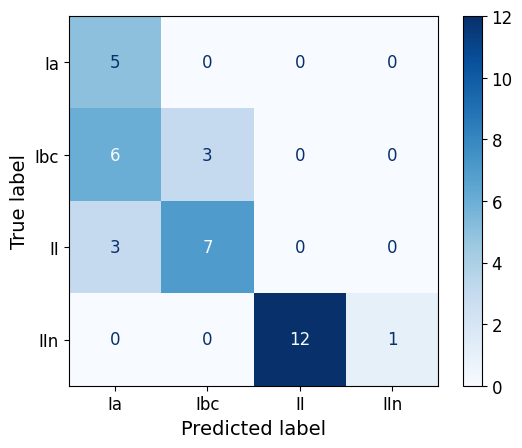

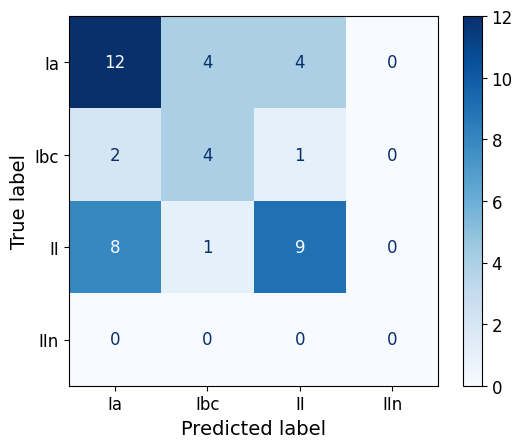

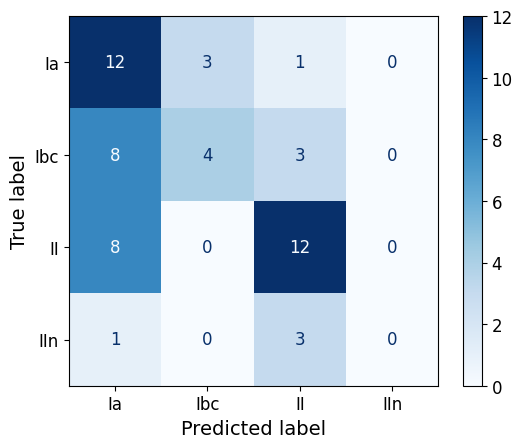

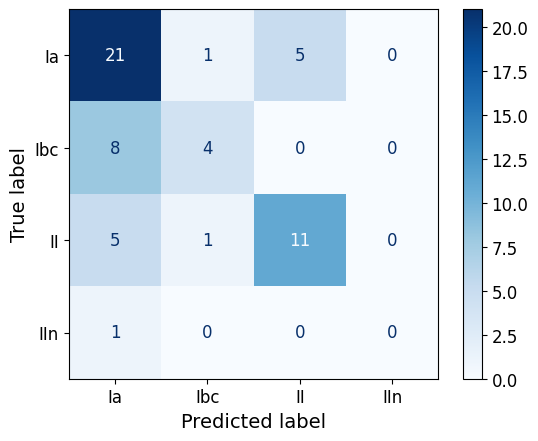

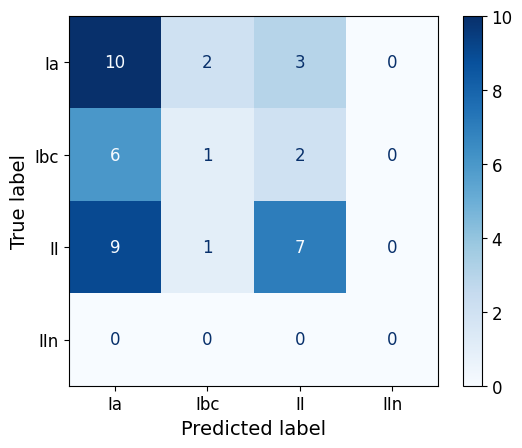

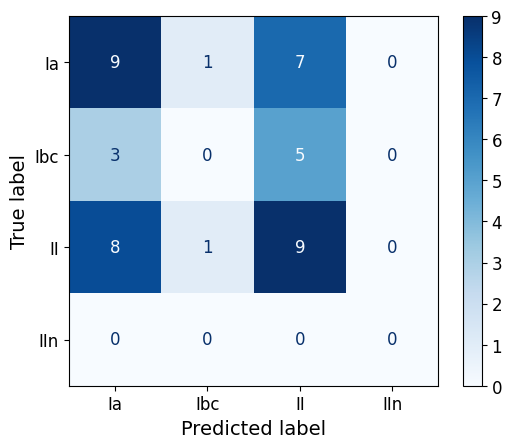

In [129]:
# Model 1 with downsampling
I_svm_down = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

I_svm_down.fit(I_X_train_down, I_y_train_down)
evaluate_model(I_svm_down, I_X_train_down, I_y_train_down, I_X_test_down, I_y_test_down, I_band_test_down, I_labels)

## Model 2

Training set:
Accuracy: 0.7506613756613757

Classification report:
               precision    recall  f1-score   support

          Ia       0.76      0.75      0.76      8846
         Ibc       0.00      0.00      0.00       423
          II       0.74      0.80      0.77      8736
         IIn       0.05      0.01      0.02       139

    accuracy                           0.75     18144
   macro avg       0.39      0.39      0.39     18144
weighted avg       0.73      0.75      0.74     18144


Confusion matrix:
 [[6603    2 2234    7]
 [ 249    0  173    1]
 [1691    2 7015   28]
 [  96    2   39    2]]

Test set:

Not classified: 0
Accuracy: 0.7500964134207482

Classification report:
               precision    recall  f1-score   support

          Ia       0.77      0.74      0.76      1264
         Ibc       0.11      0.05      0.07        60
          II       0.75      0.80      0.78      1249
         IIn       0.12      0.10      0.11        20

    accuracy                

/tmp/ipython-input-1703115811.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


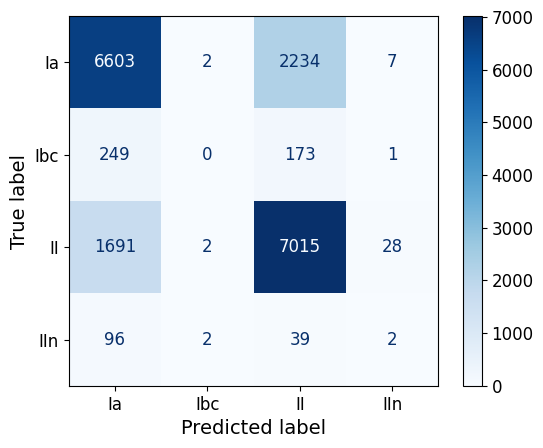

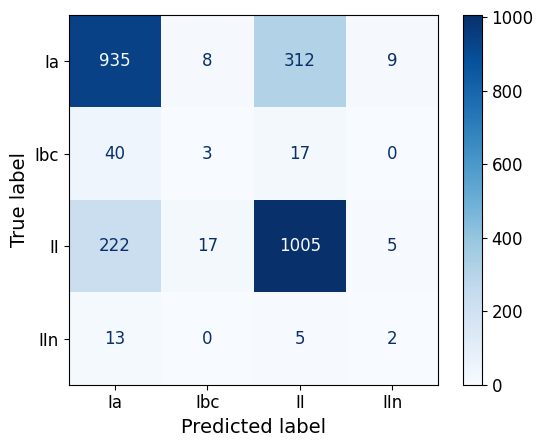

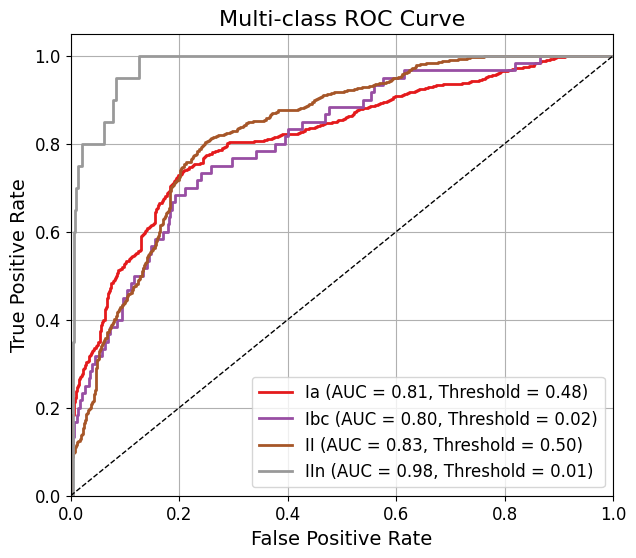


 Per-band evaluation:

--- Band = G ---
Count: 248
Accuracy: 0.6814516129032258
              precision    recall  f1-score   support

          Ia       0.67      1.00      0.80       157
         Ibc       0.00      0.00      0.00        13
          II       0.86      0.18      0.30        65
         IIn       0.00      0.00      0.00        13

    accuracy                           0.68       248
   macro avg       0.38      0.30      0.28       248
weighted avg       0.65      0.68      0.59       248

Confusion matrix:
 [[157   0   0   0]
 [ 11   0   2   0]
 [ 53   0  12   0]
 [ 13   0   0   0]]

--- Band = g' ---
Count: 477
Accuracy: 0.7945492662473794
              precision    recall  f1-score   support

          Ia       0.82      0.75      0.78       232
         Ibc       0.00      0.00      0.00         8
          II       0.77      0.87      0.82       236
         IIn       0.00      0.00      0.00         1

    accuracy                           0.79       477
   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


--- Band = z' ---
Count: 439
Accuracy: 0.765375854214123
              precision    recall  f1-score   support

          Ia       0.78      0.73      0.75       211
         Ibc       0.00      0.00      0.00         7
          II       0.76      0.83      0.79       221
         IIn       0.00      0.00      0.00         0

    accuracy                           0.77       439
   macro avg       0.38      0.39      0.39       439
weighted avg       0.76      0.77      0.76       439

Confusion matrix:
 [[153   0  57   1]
 [  6   0   1   0]
 [ 38   0 183   0]
 [  0   0   0   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

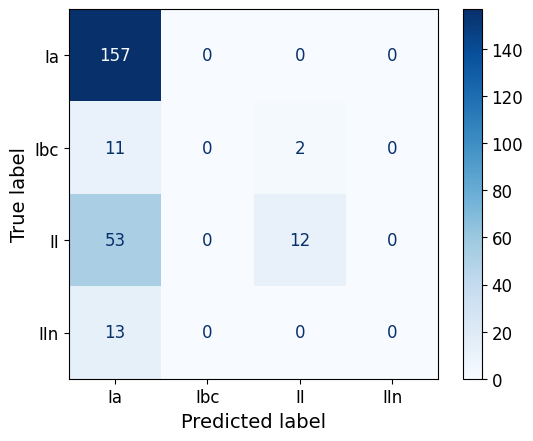

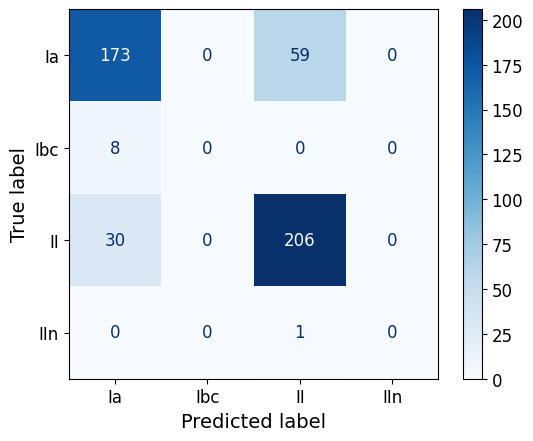

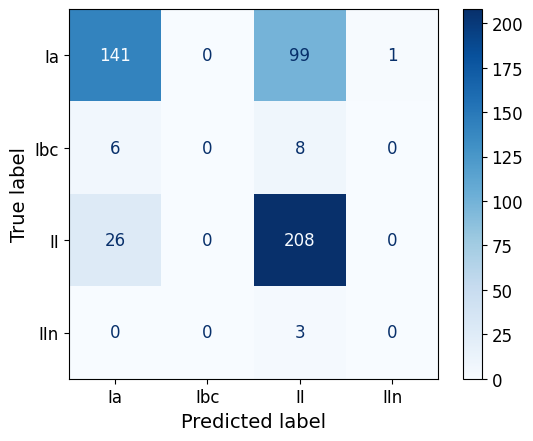

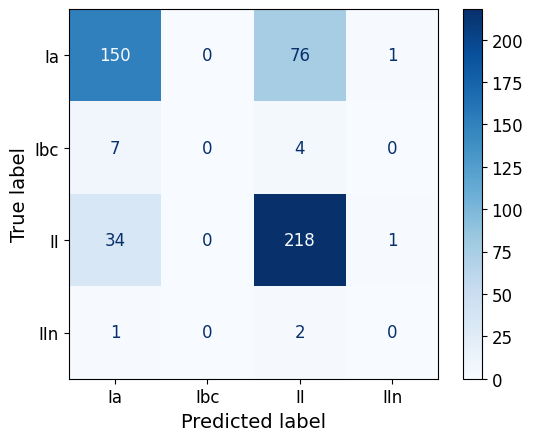

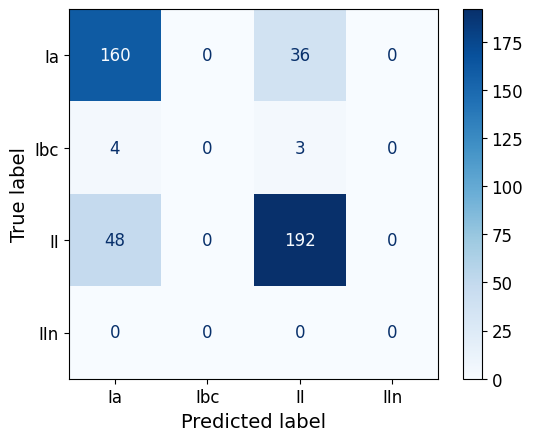

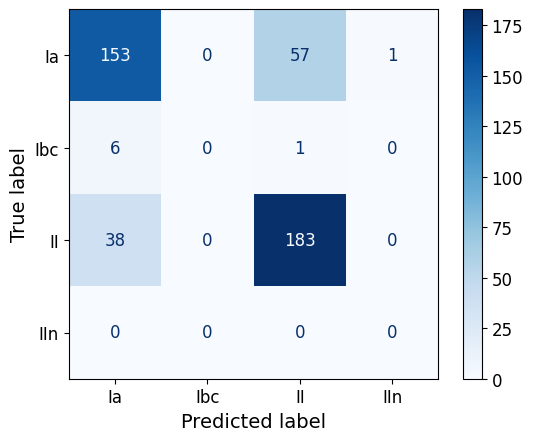

In [130]:
# Model 2 without downsampling
II_svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

II_svm.fit(II_X_train, II_y_train)
evaluate_model(II_svm, II_X_train, II_y_train, II_X_test, II_y_test, II_band_test, II_labels)

Training set:
Accuracy: 0.8447373340811367

Classification report:
               precision    recall  f1-score   support

          Ia       0.82      0.20      0.32      1400
         Ibc       0.85      0.13      0.23       423
          II       0.85      1.00      0.92      8736
         IIn       0.21      0.04      0.06       139

    accuracy                           0.84     10698
   macro avg       0.68      0.34      0.38     10698
weighted avg       0.84      0.84      0.80     10698


Confusion matrix:
 [[ 276    8 1116    0]
 [  41   56  323    3]
 [  18    2 8700   16]
 [   0    0  134    5]]

Test set:

Not classified: 0
Accuracy: 0.8378024852844996

Classification report:
               precision    recall  f1-score   support

          Ia       0.49      0.56      0.52       200
         Ibc       0.50      0.17      0.25        60
          II       0.91      0.92      0.91      1249
         IIn       0.65      0.55      0.59        20

    accuracy                

/tmp/ipython-input-1703115811.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


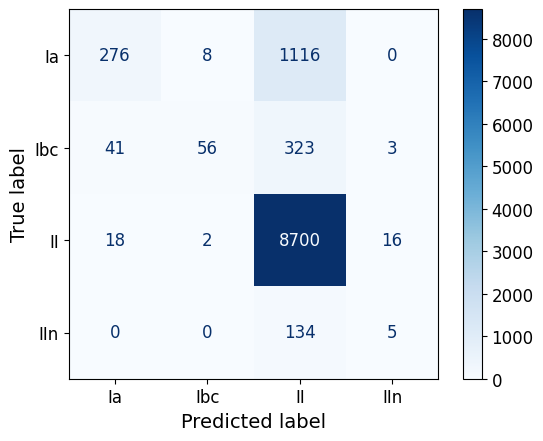

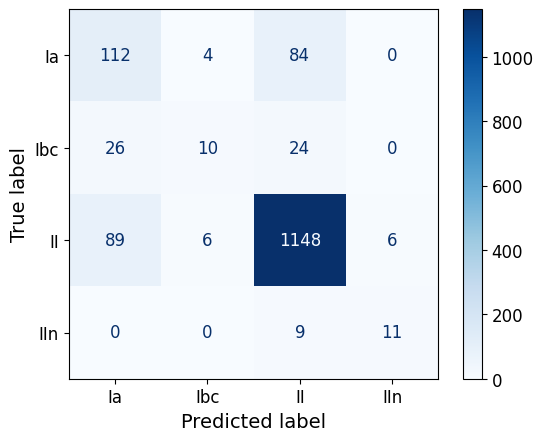

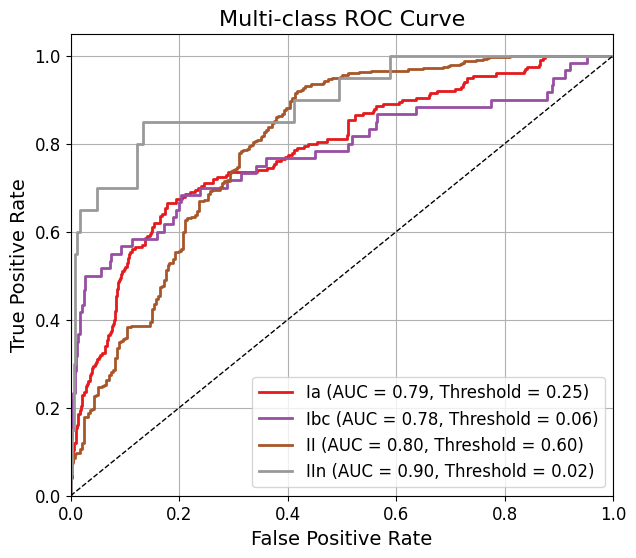


 Per-band evaluation:

--- Band = G ---
Count: 116
Accuracy: 0.6637931034482759
              precision    recall  f1-score   support

          Ia       0.75      0.15      0.25        20
         Ibc       0.00      0.00      0.00        13
          II       0.66      1.00      0.80        74
         IIn       0.00      0.00      0.00         9

    accuracy                           0.66       116
   macro avg       0.35      0.29      0.26       116
weighted avg       0.55      0.66      0.55       116

Confusion matrix:
 [[ 3  0 17  0]
 [ 1  0 12  0]
 [ 0  0 74  0]
 [ 0  0  9  0]]

--- Band = g' ---
Count: 288
Accuracy: 0.8888888888888888
              precision    recall  f1-score   support

          Ia       0.86      0.18      0.30        33
         Ibc       1.00      0.20      0.33         5
          II       0.89      1.00      0.94       250
         IIn       0.00      0.00      0.00         0

    accuracy                           0.89       288
   macro avg       

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


--- Band = u' ---
Count: 286
Accuracy: 0.8461538461538461
              precision    recall  f1-score   support

          Ia       0.56      0.12      0.20        42
         Ibc       0.00      0.00      0.00         3
          II       0.86      1.00      0.92       238
         IIn       0.00      0.00      0.00         3

    accuracy                           0.85       286
   macro avg       0.35      0.28      0.28       286
weighted avg       0.79      0.85      0.79       286

Confusion matrix:
 [[  5   0  37   0]
 [  3   0   0   0]
 [  1   0 237   0]
 [  0   0   3   0]]

--- Band = z' ---
Count: 262
Accuracy: 0.8435114503816794
              precision    recall  f1-score   support

          Ia       0.67      0.11      0.19        37
         Ibc       1.00      0.12      0.22         8
          II       0.85      1.00      0.92       216
         IIn       0.00      0.00      0.00         1

    accuracy                           0.84       262
   macro avg       0.63  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

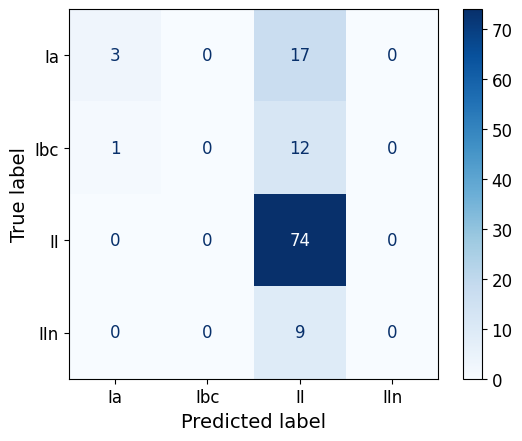

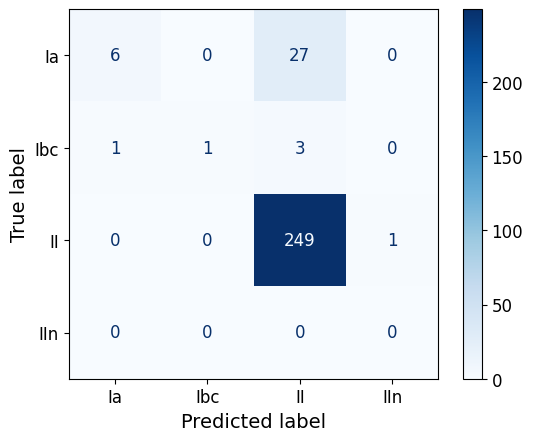

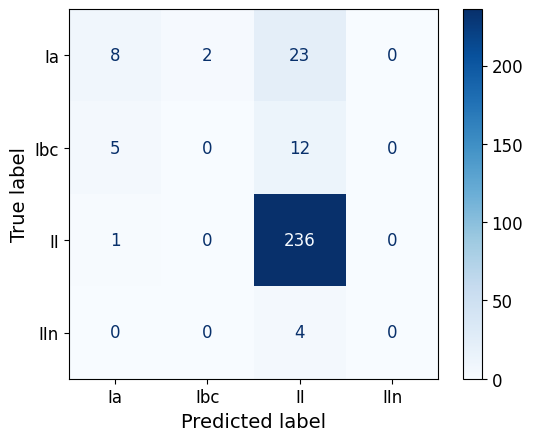

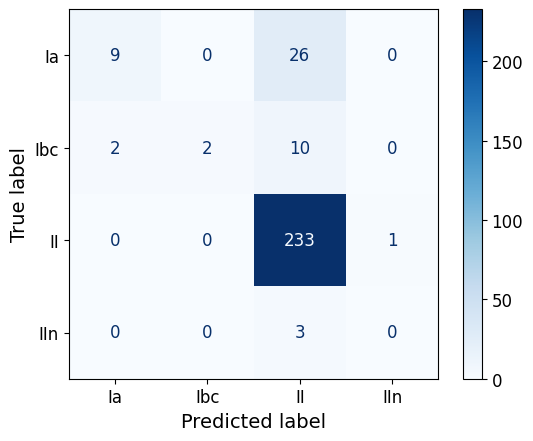

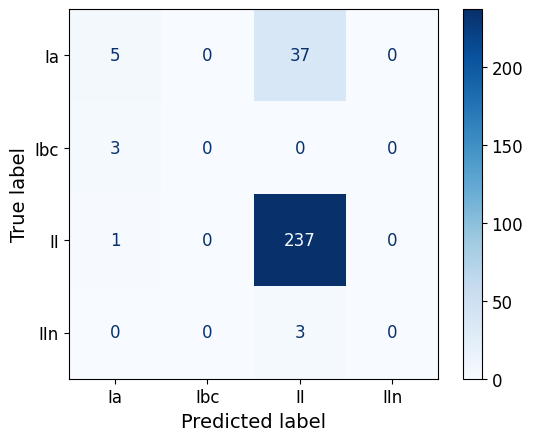

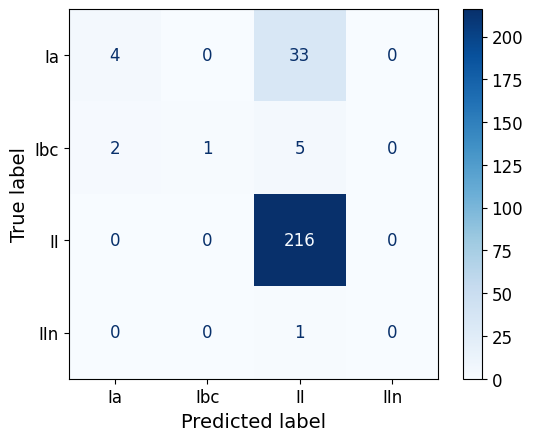

In [131]:
# Model 2 with downsampling
II_svm_down = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

II_svm_down.fit(II_X_train_down, II_y_train_down)
evaluate_model(II_svm_down, II_X_train_down, II_y_train_down, II_X_test_down, II_y_test_down, II_band_test_down, II_labels)

Observation: Model 2 outperforms Model 1 without downsampling. Downsampling makes it worse for the classifier.

Conclusion:
- Data preprocessing is very important, which in our case is necessary to handle outliers.
- Model 2 outperforms Model 1. Probably because it has more features.
- Boosted decision tree classifier is the most effective, which agrees with the paper.
- Downsampling does not improve classification. The reason might be that our downsampling process results in a too small dataset, making it difficult for the classifiers to learn.
- In Model 2, we did a better job than the paper. Yay 😎!